# Tarea sobre Q-learning reforzado

Para esta tarea, utilizando como base el codigo del video del siguiente link: 
<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_02_qlearningreinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Y para comprender el codigo, se tiene este link con la explicacion del mismo:


https://www.youtube.com/watch?v=A3sYFcJY3lA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN




Primeramente, se configura el Google Collab para que trabaje con la version correcta de TensorFlow

# Part 12.2: Introduction to Q-Learning

Q-Learning is a foundational technique upon which deep reinforcement learning is based.  Before we explore deep reinforcement learning, it is essential to understand Q-Learning.  Several components make up any Q-Learning system.

* **Agent** - The agent is an entity that exists in an environment that takes actions to affect the state of the environment, to receive rewards.
* **Environment** - The environment is the universe that the agent exists in.  The environment is always in a specific state that is changed by the actions of the agent.
* **Actions** - Steps that can be performed by the agent to alter the environment 
* **Step** - A step occurs each time that the agent performs an action and potentially changes the environment state.
* **Episode** - A chain of steps that ultimately culminates in the environment entering a terminal state.
* **Epoch** - A training iteration of the agent that contains some number of episodes.
* **Terminal State** -  A state in which further actions do not make sense.  In many environments, a terminal state occurs when the agent has one, lost, or the environment exceeding the maximum number of steps.

Q-Learning works by building a table that suggests an action for every possible state.  This approach runs into several problems.  First, the environment is usually composed of several continuous numbers, resulting in an infinite number of states. Q-Learning handles continuous states by binning these numeric values into ranges. 

Additionally, Q-Learning primarily deals with discrete actions, such as pressing a joystick up or down.  Out of the box, Q-Learning does not deal with continuous inputs, such as a car's accelerator that can be in a range of positions from released to fully engaged. Researchers have come up with clever tricks to allow Q-Learning to accommodate continuous actions.


# Pendulo Invertido (Pendulum-v0)

El pendulo invertido es un problema clasico en la literatura de control. En esta version del problema, el pendulo inicia en una posicion aleatoria, y el objetivo es girar el mismo para que se quede verticalmente hacia arriba.

El source code del pendulo esta en este enlace:

https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py

La wiki del pendulo esta disponible en el siguiente enlace:

https://github.com/openai/gym/wiki/Pendulum-v0

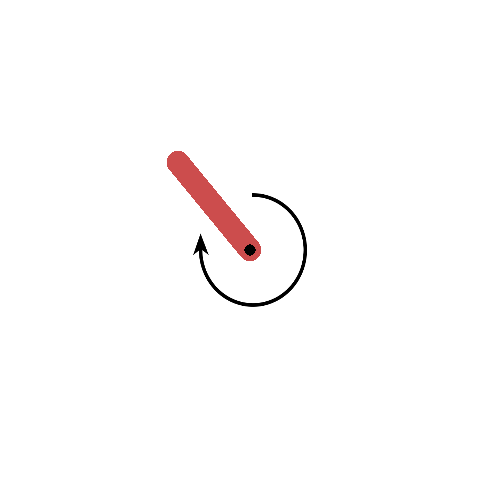

In [8]:
import tf_agents
from tf_agents.environments import suite_gym
import PIL.Image


env_name = 'Pendulum-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())


# Controles:
Espacio de accion (continuo)

* action[0] $\leftarrow$ Torque aplicado al pendulo. Rango: (-2.0,+2.0) 

The mountain car environment is made up of the following continuous values:

* state[0] $\leftarrow$ Angulo del pendulo
* state[1] $\leftarrow$ Velocidad del pendulo

La funcion de recompensa por defecto depende del angulo del pendulo. Si el pendulo esta completamente vertical hacia arriba, el mismo recibe la recompensa maxima. 

Primeramente, se inicializa el codigo necesario para poder visualizar el movimiento del pendulo

In [3]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64



#Primera prueba
Para la primera implementacion, el pendulo recibira un torque de 1.0 hasta llegar al objetivo

In [4]:
import gym

env = gym.make("Pendulum-v0")

env.reset()
done = False

i = 0
while not done:
    i += 1
    state, reward, done, _ = env.step([1.0])
    env.render()
    print(f"Step {i}: State={state}, Reward={reward}")
    
env.close()

Step 1: State=[-0.14600657  0.98928362  0.99750294], Reward=-2.7824148361995538
Step 2: State=[-0.23867739  0.97109892  1.88946565], Reward=-3.049712187034412
Step 3: State=[-0.37035683  0.92888956  2.76778984], Reward=-3.6406272024463675
Step 4: State=[-0.53128447  0.84719349  3.61445701], Reward=-4.570305024379857
Step 5: State=[-0.70335662  0.71083716  4.39985213], Reward=-5.848217260280256
Step 6: State=[-0.8594831   0.51116415  5.08298   ], Reward=-7.463623844743724
Step 7: State=[-0.96748116  0.2529431   5.61635311], Reward=-9.370974519607858
Step 8: State=[-0.99911469 -0.04206953  5.95606044], Reward=-11.48359701133636
Step 9: State=[-0.9408021  -0.33895636  6.07450829], Reward=-13.15543219581458
Step 10: State=[-0.79950725 -0.60065644  5.97029102], Reward=-11.507380479973756
Step 11: State=[-0.59958661 -0.80030987  5.66979869], Reward=-9.801798628604155
Step 12: State=[-0.37278277 -0.92791864  5.21956628], Reward=-8.116487165667667
Step 13: State=[-0.14778153 -0.98902003  4.673

### Pendulo Programado


Ahora programamos el pendulo para llegar al objetivo. Se le imponen ciertas reglas para indicar que torque a emplear. Inicialmente, voy a darle un torque de +2.0 para iniciar el movimiento. Seguido de ello, cada que el pendulo este en un angulo positivo y su velocidad llegue a cero, voy a darle un torque de -0.65 para impulsarlo en el sentido contrario. Analogamente, cuando el pendulo este en un angulo negativo y su velocidad llega a cero, le doy un torque de 0.65

In [5]:
import gym

env = gym.make("Pendulum-v0")
  
state = env.reset()
done = False
#Aqui le doy el torque inicial
state, reward, done, _ = env.step([2.0])
i = 1
while not done:
    i += 1
    #Aqui impongo las condiciones para darle otro torque al pendulo
    if (state[0]>0) and (state[1]==0):
        action = -0.5
    elif (state[0]<0) and (state[1]==0):
        action= 0.5
    else:
        action =0
    
    state, reward, done, _ = env.step([action])
    env.render()
    print(f"Step {i}: State={state}, Reward={reward}")
    
env.close()

Step 2: State=[0.27268932 0.96210214 1.14915014], Reward=-1.549948971326095
Step 3: State=[0.18163696 0.98336566 1.87072675], Reward=-1.8080674328955084
Step 4: State=[0.05221454 0.99863589 2.60825099], Reward=-2.276909727109774
Step 5: State=[-0.11536565  0.99332309  3.35722791], Reward=-2.9863158094402387
Step 6: State=[-0.31526332  0.94900424  4.10222023], Reward=-3.9711083977113955
Step 7: State=[-0.53239958  0.84649317  4.81397341], Reward=-5.260708470428522
Step 8: State=[-0.74054093  0.67201126  5.44884329], Reward=-6.863834957432022
Step 9: State=[-0.90505862  0.42528684  5.95285173], Reward=-8.751433232196547
Step 10: State=[-0.99211166  0.12535729  6.27181686], Reward=-10.846144550533436
Step 11: State=[-0.98150916 -0.19141518  6.36583483], Reward=-13.029249834098616
Step 12: State=[-0.87579426 -0.4826846   6.22227344], Reward=-12.748920641186743
Step 13: State=[-0.69904841 -0.71507435  5.86026   ], Reward=-10.830054219360584
Step 14: State=[-0.48631558 -0.87378324  5.3239542

We now visualize the preprogrammed car solving the problem.

### Reinforcement Learning

Q-Learning is a system of rewards that the algorithm gives an agent for successfully moving the environment into a state considered successful.  These rewards are the Q-values from which this algorithm takes its name.  The final output from the Q-Learning algorithm is a table of Q-values that indicate the reward value of every action that the agent can take, given every possible environment state. The agent must bin continuous state values into a fixed finite number of columns.

Learning occurs when the algorithm runs the agent and environment through a series of episodes and updates the Q-values based on the rewards received from actions taken; Figure 12.REINF provides a high-level overview of this reinforcement or Q-Learning loop.

**Figure 12.REINF:Reinforcement/Q Learning**
![Reinforcement Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/reinforcement.png "Reinforcement Learning")

The Q-values can dictate action by selecting the action column with the highest Q-value for the current environment state.  The choice between choosing a random action and a Q-value driven action is governed by the epsilon ($\epsilon$) parameter, which is the probability of random action.

Each time through the training loop, the training algorithm updates the Q-values according to the following equation.


$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{old value}} \bigg) }^{\text{temporal difference}}$

There are several parameters in this equation:
* alpha ($\alpha$) - The learning rate, how much should the current step cause the Q-values to be updated.
* lambda ($\lambda$) - The discount factor is the percentage of future reward that the algorithm should consider in this update.

This equation modifies several values:

* $Q(s_t,a_t)$ - The Q-table.  For each combination of states, what reward would the agent likely receive for performing each action?
* $s_t$ - The current state.
* $r_t$ - The last reward received.
* $a_t$ - The action that the agent will perform.

The equation works by calculating a delta (temporal difference) that the equation should apply to the old state.  This learning rate ($\alpha$) scales this delta.  A learning rate of 1.0 would fully implement the temporal difference to the Q-values each iteration and would likely be very chaotic.

There are two parts to the temporal difference: the new and old values.  The new value is subtracted from the old value to provide a delta; the full amount that we would change the Q-value by if the learning rate did not scale this value.  The new value is a summation of the reward received from the last action and the maximum of the Q-values from the resulting state when the client takes this action. It is essential to add the maximum of action Q-values for the new state because it estimates the optimal future values from proceeding with this action. 


#Pendulo con Q-learning

In [40]:
import gym
import numpy as np

# This function converts the floating point state values into 
# discrete values. This is often called binning.  We divide 
# the range that the state values might occupy and assign 
# each region to a bucket.
def calc_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/buckets
    return tuple(discrete_state.astype(np.int))  

# Run one game.  The q_table to use is provided.  We also 
# provide a flag to indicate if the game should be 
# rendered/animated.  Finally, we also provide
# a flag to indicate if the q_table should be updated.
def run_game(q_table, render, should_update):
    done = False
    discrete_state = calc_discrete_state(env.reset())
    success = False
    
    while not done:
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action 
            # (and probably refine)
            action = np.argmax(q_table[discrete_state])
        else:
            # Explore - t
            action = np.random.randint(0, env.action_space.n)
            
        # Run simulation step
        new_state, reward, done, _ = env.step(action)
        
        # Convert continuous state to discrete
        new_state_disc = calc_discrete_state(new_state)

        # Have we reached the goal position (have we won?)?
       # if new_state[0] >= env.unwrapped.goal_position:
        #    success = True
        if done:
            success  = True  
        # Update q-table
        if should_update:
            max_future_q = np.max(q_table[new_state_disc])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * \
              (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_state_disc
        
        #if render:
          # env.render()
    return success


Several hyperparameters are very important for Q-Learning. These parameters will likely need adjustment as you apply Q-Learning to other problems.  Because of this, it is crucial to understand the role of each parameter.

* **LEARNING_RATE** The rate at which previous Q-values are updated based on new episodes run during training. 
* **DISCOUNT** The amount of significance to give estimates of future rewards when added to the reward for the current action taken.  A value of 0.95 would indicate a discount of 5% to the future reward estimates. 
* **EPISODES** The number of episodes to train over.  Increase this for more complex problems; however, training time also increases.
* **SHOW_EVERY** How many episodes to allow to elapse before showing an update.
* **DISCRETE_GRID_SIZE** How many buckets to use when converting each of the continuous state variables.  For example, [10, 10] indicates that the algorithm should use ten buckets for the first and second state variables.
* **START_EPSILON_DECAYING** Epsilon is the probability that the agent will select a random action over what the Q-Table suggests. This value determines the starting probability of randomness.
* **END_EPSILON_DECAYING** How many episodes should elapse before epsilon goes to zero and no random actions are permitted. For example, EPISODES//10  means only the first 1/10th of the episodes might have random actions.

In [50]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 5000
SHOW_EVERY = 10

DISCRETE_GRID_SIZE = [20] * len(env.observation_space.high)
START_EPSILON_DECAYING = 0.5
END_EPSILON_DECAYING = EPISODES//10

We can now make the environment.  If we are running in Google COLAB then we wrap the environment to be displayed inside the web browser.  Next create the discrete buckets for state and build Q-table.

In [51]:

env = gym.make("CartPole-v0")

epsilon = 1  
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
buckets = (env.observation_space.high - env.observation_space.low) \
    /DISCRETE_GRID_SIZE
q_table = np.random.uniform(low=-3, high=0, size=(DISCRETE_GRID_SIZE + [env.action_space.n]))
success = False

<ipython-input-51-c56f749ab164>:5: RuntimeWarning: overflow encountered in subtract
  buckets = (env.observation_space.high - env.observation_space.low) \


We can now make the environment.  If we are running in Google COLAB then we wrap the environment to be displayed inside the web browser.  Next, create the discrete buckets for state and build Q-table.

In [52]:
episode = 0
success_count = 0

# Loop through the required number of episodes
while episode<EPISODES:
    episode+=1
    done = False

    # Run the game.  If we are local, display render animation at SHOW_EVERY
    # intervals. 
    if episode % SHOW_EVERY == 0:
        print(f"Current episode: {episode}, success: {success_count} ({float(success_count)/SHOW_EVERY})")
        success = run_game(q_table, True, False)
        success_count = 0
    else:
        success = run_game(q_table, False, True)
        
    # Count successes
    if success:
        success_count += 1

    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)

print(success)

Current episode: 10, success: 9 (0.9)
Current episode: 20, success: 10 (1.0)
Current episode: 30, success: 10 (1.0)
Current episode: 40, success: 10 (1.0)
Current episode: 50, success: 10 (1.0)
Current episode: 60, success: 10 (1.0)
Current episode: 70, success: 10 (1.0)
Current episode: 80, success: 10 (1.0)
Current episode: 90, success: 10 (1.0)
Current episode: 100, success: 10 (1.0)
Current episode: 110, success: 10 (1.0)
Current episode: 120, success: 10 (1.0)
Current episode: 130, success: 10 (1.0)
Current episode: 140, success: 10 (1.0)
Current episode: 150, success: 10 (1.0)
Current episode: 160, success: 10 (1.0)
Current episode: 170, success: 10 (1.0)
Current episode: 180, success: 10 (1.0)
Current episode: 190, success: 10 (1.0)
Current episode: 200, success: 10 (1.0)
Current episode: 210, success: 10 (1.0)
Current episode: 220, success: 10 (1.0)
Current episode: 230, success: 10 (1.0)
Current episode: 240, success: 10 (1.0)
Current episode: 250, success: 10 (1.0)
Current ep

As you can see, the number of successful episodes generally increases as training progresses.  It is not advisable to stop the first time that we observe 100% success over 1,000 episodes. There is a randomness to most games, so it is not likely that an agent would retain its 100% success rate with a new run.  Once you observe that the agent has gotten 100% for several update intervals, it might be safe to stop training.

# Running and Observing the Agent

Now that the algorithm has trained the agent, we can observe the agent in action. You can use the following code to see the agent in action.

In [53]:
run_game(q_table, True, False)


True

# Inspecting the Q-Table

We can also display the Q-table.  The following code shows the action that the agent would perform for each environment state.  As the weights of a neural network, this table is not straightforward to interpret.  Some patterns do emerge in that directions do arise, as seen by calculating the means of rows and columns. The actions seem consistent at upper and lower halves of both velocity and position.

In [54]:
import pandas as pd

df = pd.DataFrame(q_table.argmax(axis=2))

df.columns = [f'v-{x}' for x in range(DISCRETE_GRID_SIZE[0])]
df.index = [f'p-{x}' for x in range(DISCRETE_GRID_SIZE[1])]
df

ValueError: Must pass 2-d input. shape=(20, 20, 20, 2)

In [ ]:
df.mean(axis=0)

v-0    0.7
v-1    0.6
v-2    0.7
v-3    0.6
v-4    0.3
v-5    1.1
v-6    1.1
v-7    1.3
v-8    1.3
v-9    1.6
dtype: float64

In [ ]:
df.mean(axis=1)

p-0    1.0
p-1    0.9
p-2    1.2
p-3    0.8
p-4    0.9
p-5    1.1
p-6    0.5
p-7    0.7
p-8    1.2
p-9    1.0
dtype: float64